*(to use GPU in colab go to Runtime -> Change Runtime Type and change the hardware accelerator)*

In [14]:
# some prelimenaries
from torchvision.datasets import MNIST, SVHN
from torchvision import transforms
import torch
from torch import nn
from torch.distributions import Normal, Bernoulli, Independent, kl_divergence
import numpy as np
import matplotlib.pylab as plt

TINY = 1e-8

torch.manual_seed(0)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('Using torch version {}'.format(torch.__version__))
print('Using {} device'.format(device))
  
# Training dataset
train_loader = torch.utils.data.DataLoader(
    MNIST(root='../../data/', train=True, download=True,
          transform=transforms.ToTensor()),
    batch_size=100, shuffle=True, pin_memory=True)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    MNIST(root='../../data/', train=False, transform=transforms.ToTensor()),
    batch_size=100, shuffle=True, pin_memory=True)

Using torch version 1.2.0
Using cpu device


# Practical Session. Variational Autoencoders

During this practical session, you will implement a vanilla VAE on MNIST and then a VAE extension with multiple latent variables. Both implementations will be based on classes for parametric probabilistic distributions from the torch [*torch.distributions*](https://pytorch.org/docs/stable/distributions.html) module to emphasize the probabilistic nature of the models.

To complete the task, you will have read the notebook and construct two loss functions using the classes and then train the models.

# AEs  vs. VAEs

As illustrated below, autoencoders can provide good reconstruction quality. 

![Autoencoder reconstructions](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/ae_reconstructions.png?raw=true)

Still, the model has no control over the learned latent representations. For example, an interpolation of latent representations of two digits is typically not a latent representation for a digit:

![Autoencoder interpolations](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/ae_interpolations.png?raw=true)

On the other hand, a standard VAE model forces latent representation to fit a multivariate Gaussian distribution. As a result, an interpolation of two latent representations is likely to be a latent representation of a digit.

# Distributions for VAE

For the assignment, we will need two types of distributions to define the probabilistic model. For the representation $z$ we need a multivariate [normal distribution](https://pytorch.org/docs/stable/distributions.html#normal) with diagonal covariance matrix (to put another way, a vector of independent normal random variables). For observations $x$, we will need a vector of independent [Bernoulli](https://pytorch.org/docs/stable/distributions.html#bernoulli) random variables. By default, both classes model a tensor of independent random **variables**. To represent a matrix of independent random variables as a batch of random **vectors** you may also use the [Independent](https://pytorch.org/docs/stable/distributions.html#independent) class.

### Bernoulli random vector

While the class can be initialized both with probabilities and logits, the best practice is to initialize the class with logits. Otherwise, computing logarithm of probability can be highly unstable. 

In the tasks, you will use this class to model $p(x | z)$ parametrized by the output of the decoder. To define the loss function you will need to compute $\log p(x | z)$ for input images using *log_prob()* method.

### Normal Distribution

In this task, you will use the class to define the approximate posterior distribution $q(x | z)$ and the latent variable distribution $p(z)$.

Again, you will use *log_prob()* method to compute the loss function. Besides that, you will need to generate a sample from $q(x | z)$ to pass it to the decoder. To implement the reparametrization trick the class defines a specific method *rsample()*, that computes $z = \mu(x) + \varepsilon \odot \sigma(x)$ for standard Gaussian noise $\varepsilon$. Notice that the implementation of *rsample()* method differs from the implementation of *sample()* method.

In [2]:
# from torch.distributions import Normal, Bernoulli, Independent, kl_divergence

# Vanilla VAE

A variational autoencoder consists of two components. The first component is a probabilistic model for observations: 
\begin{align}
& p(x, z \mid \theta) =  p(z) p(x \mid z, \theta) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid z, \theta) = \prod_{i = 1}^D p_i(z, \theta)^{x_i} (1 - p_i(z, \theta))^{1 - x_i}.
\end{align}
The second component is a variational approximation, used to compute the lower bound on marginal likelihood (VAE uses the negative lower bound as a loss function)
\begin{equation}
q(z \mid x, \phi) = \mathcal N(z \mid \mu(x, \phi), \operatorname{diag}(\sigma^2(x, \phi))).
\end{equation}
The lower bound for probability of observing $x$ from a minibatch is
$$ \mathcal L(x, \theta, \phi) = \mathbb E_{q(z \mid x, \phi)} \left[ \log p(x \mid z, \phi) + \log p(z) - \log q(z \mid x, \theta) \right] $$
However, it is impossible to compute the expectation. The standard practice is to approximate it with the following one-sample Monte-Carlo estimate:
\begin{align*}
\log p(x \mid z_0, \phi) + \log p(z_0) - \log q(z_0 \mid x, \theta) \\
z_0 = \mu(x, \phi) + \sigma^2(x, \phi)^T \varepsilon_0 \\
\varepsilon_0 \sim \mathcal N(0, I)
\end{align*}
*Note that this choice of the Monte-Carlo estimate for expectation is crucial and is typically reffered to as* **reparametrization trick.** For more details see [Auto-encoding Variational Bayes](https://arxiv.org/abs/1312.6114) paper.

Finally, to train the model we average the lower bound values over the minibatch and then maximize the average with gradient ascent:
$$ \frac{1}{N} \sum_{n=1}^N \log p(x_n \mid z_n, \phi) + \log p(z_n) - \log q(z_n \mid x_n, \theta) \rightarrow \max_{\theta, \phi} $$
## Encoder and decoder

$q(z\mid x, \theta)$ is usually called encoder and $p(x \mid z, \phi)$ is usually called decoder. To parametrize these distributions we introduce two neural networks:

- *enc* takes $x$ as input and return $2 \times d$-dimensional vector to parametrize mean and standard deviation of $q(z \mid x, \theta)$
- *dec* takes a latent representation $z$ and returns the logits of distribution $p(x \mid z, \phi)$.

The computational graph has a simple structure of autoencoder. The only difference is that now it uses a stochastic variable $\varepsilon$:

![vae](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/vae.png?raw=true)

Below we initialize a couple of simple fully-connected networks to model the two distributions. 

In [7]:
d, nh, D = 32, 100, 28 * 28

enc = nn.Sequential(
    nn.Linear(D, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, 2 * d)) # note that the final layer outputs real values

dec = nn.Sequential(
    nn.Linear(d, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, D))# <-----------------------------------------------

enc = enc.to(device)
dec = dec.to(device)

## Using *Independent* class

### Bernoulli

In [8]:
rand_vec = np.random.randn(20, 10)

dist1 = Bernoulli(logits=torch.from_numpy(rand_vec))
dist2 = Independent(
    Bernoulli(logits=torch.from_numpy(rand_vec)),
    reinterpreted_batch_ndims=1
)
sample = dist1.sample() # samples will be from the same distribution, since multidimensional Bernoulli assumes idenpendence among components
print(dist1.log_prob(sample).sum(axis=1))
print(dist2.log_prob(sample))

tensor([-6.0042, -7.6946, -6.1313, -5.1757, -6.7454, -6.3258, -7.6820, -6.9846,
        -3.9756, -4.9860, -4.8172, -5.1661, -5.5503, -5.2448, -4.2265, -7.6619,
        -8.4558, -6.9867, -5.8436, -6.2158], dtype=torch.float64)
tensor([-6.0042, -7.6946, -6.1313, -5.1757, -6.7454, -6.3258, -7.6820, -6.9846,
        -3.9756, -4.9860, -4.8172, -5.1661, -5.5503, -5.2448, -4.2265, -7.6619,
        -8.4558, -6.9867, -5.8436, -6.2158], dtype=torch.float64)


### Gaussian

In [9]:
sample = torch.randn(3)

loc = torch.zeros(3)
scale = torch.ones(3)

multi_normal_dist = torch.distributions.MultivariateNormal(loc, scale_tril=torch.diag(scale))
print(multi_normal_dist.batch_shape, multi_normal_dist.event_shape)
print(multi_normal_dist.log_prob(sample))

normal_dist = Normal(loc, scale)
print(normal_dist.batch_shape, normal_dist.event_shape)
print(normal_dist.log_prob(sample)) # only equal in sum to the above because it's a diagonal covariance

reint_normal_dist = Independent(normal_dist, reinterpreted_batch_ndims=1)
print(reint_normal_dist.batch_shape, reint_normal_dist.event_shape)
print(reint_normal_dist.log_prob(sample))

torch.Size([]) torch.Size([3])
tensor(-3.0788)
torch.Size([3]) torch.Size([])
tensor([-1.2022, -0.9489, -0.9277])
torch.Size([]) torch.Size([3])
tensor(-3.0788)


## Task 1: VAE Loss function

Implement the loss function for the variational autoencoder

In [10]:
def loss_vae(x, encoder, decoder):
    """
    TODO
    returns
    1. the avergave value of negative ELBO across the minibatch x
    2. and the output of the decoder
    """
    
    # -------- encoder step:
    # parametrize a Normal distribution with the output of the encoder (d-dimensional)
    # and sample z ~ N(mu(x), sigma(x)) through the member function rsample
    z_dist_params = encoder(x)
    z_mu, z_log_sigma = z_dist_params[:, :d], z_dist_params[:, d:]
    
    z_dist = Normal(z_mu, torch.exp(z_log_sigma))
    # z_dist = Independent(Normal(z_mu, torch.exp(z_log_sigma)), reinterpreted_batch_ndims=1)
    
    z_sample = z_dist.rsample()
    
    # -------- decoder step:
    # parametrize a Bernoulli distribution (logits!) with the output of the decoder (D-dimensional)
    x_dist_params = decoder(z_sample)
    
    x_dist = Bernoulli(logits=x_dist_params)
    # x_dist = Independent(Bernoulli(logits=x_dist_params), reinterpreted_batch_ndims=1)
    
    # prior distribution N(0,1)
    prior_dist = Normal(torch.zeros_like(z_mu), torch.ones_like(z_log_sigma))
    # prior_dist = Independent(Normal(torch.zeros_like(z_mu), torch.ones_like(z_log_sigma)), reinterpreted_batch_ndims=1)
    
    #--------- compute losses:
    
    # the reconstruction loss is the negative log likelihood of x under the decoder distribution.
    # It's important to sum along the component/parameter axis and to average along the batch axis
    rec_loss = - x_dist.log_prob(x).sum(axis=1).mean(axis=0)
    # rec_loss = - x_dist.log_prob(x).mean(axis=0)
    
    # that's log p(z) - log q(z|x)
    # it can also be computed analytically for Gaussians, which they chose not to do in this tutorial I think
    # but was done in the original paper.
    # kl_loss = - (prior_dist.log_prob(z_sample) - z_dist.log_prob(z_sample)).sum(axis=1).mean(axis=0)
    # kl_loss = - (prior_dist.log_prob(z_sample) - z_dist.log_prob(z_sample)).mean() # if using Independent
    
    # analytic by hand
    # kl_numerator = (z_dist.mean - prior_dist.mean)**2 + z_dist.stddev**2 - prior_dist.stddev**2
    # kl_denominator = 2. * prior_dist.stddev**2
    # kl_loss = (kl_numerator / (kl_denominator + 1e-10)
    #           + torch.log(prior_dist.stddev + 1e-10)
    #           - torch.log(z_dist.stddev + 1e-10)).sum(axis=1).mean(axis=0)
    
    # analytic in pytorch
    kl_loss = kl_divergence(z_dist, prior_dist).sum(axis=1).mean(axis=0)
    # kl_loss = kl_divergence(z_dist, prior_dist).mean() # if using Independent
    
    # Alternative decoder output:
    decoder_output_sample = x_dist_params
    decoder_output_map = decoder(z_mu)
        
    loss = rec_loss + kl_loss
    return loss, decoder_output_sample, decoder_output_map

## Training
The cell below implements a simple training function that can be used for both models.

In [12]:
from itertools import chain

def train_model(loss, model, batch_size=100, num_epochs=3, learning_rate=1e-3):
    params = ([x.parameters() for x in model if isinstance(x, nn.Module)] 
              + [x for x in model if isinstance(x, nn.Parameter)])
    
    gd = torch.optim.Adam(chain(*params), lr=learning_rate)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(train_loader):
            total = len(train_loader)
            gd.zero_grad()
            batch = batch.view(-1, D).to(device)
            import pdb; pdb.set_trace()
            loss_value, _, _ = loss(batch, *model)
            loss_value.backward()
            train_losses.append(loss_value.item())
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            gd.step()
        test_loss = 0.
        for i, (batch, _) in enumerate(test_loader):
            batch = batch.view(-1, D).to(device)
            batch_loss, _, _ = loss(batch, *model)
            test_loss += (batch_loss - test_loss) / (i + 1)
        print('\nTest loss after an epoch: {}'.format(test_loss))

In [ ]:
# my implementation has test loss = -110.59
train_model(loss_vae, model=[enc, dec], num_epochs=16)

## Visualisations

- How do reconstruction compare to reconstructions of autoencoder?
- Interpolations?
- Is the latent space regularly covered? 
- Is there any dependence between T-SNE encoding and the digit label?

In [143]:
def sample_vae(dec, n_samples=50):
    with torch.no_grad():
        samples = torch.sigmoid(dec(torch.randn(n_samples, d).to(device)))
        samples = samples.view(n_samples, 28, 28).cpu().numpy()
    return samples
    
def plot_samples(samples, h=5, w=10):
    fig, axes = plt.subplots(nrows=h,
                             ncols=w,
                             figsize=(int(1.4 * w), int(1.4 * h)),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap='gray')

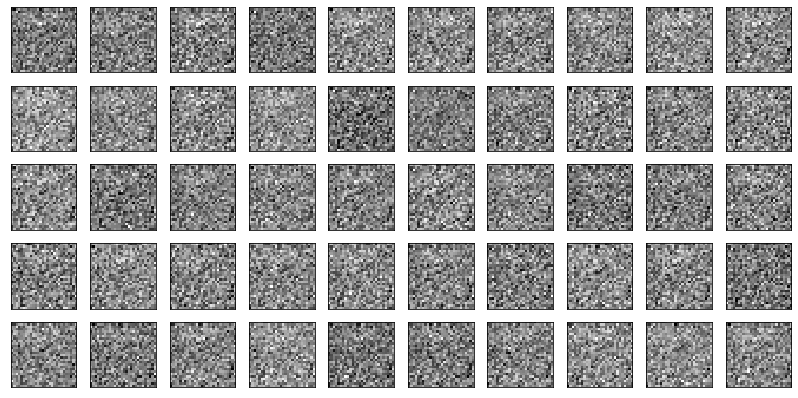

In [193]:
plot_samples(sample_vae(dec=dec))

In [8]:
def plot_reconstructions(loss, model):
    with torch.no_grad():
        batch = (test_loader.dataset.data[:25].float() / 255.)
        batch = batch.view(-1, D).to(device)
        _, rec_sample, rec_map = loss(batch, *model)
        rec_sample = torch.sigmoid(rec_sample)
        rec_sample = rec_sample.view(-1, 28, 28).cpu().numpy()
        rec_map = torch.sigmoid(rec_map)
        rec_map = rec_map.view(-1, 28, 28).cpu().numpy()
        batch = batch.view(-1, 28, 28).cpu().numpy()
    
        fig, axes = plt.subplots(nrows=5, ncols=15, figsize=(14, 7),
                                 subplot_kw={'xticks': [], 'yticks': []})
        for i in range(25):
            axes[i % 5, 3 * (i // 5)].imshow(batch[i], cmap='gray')
            axes[i % 5, 3 * (i // 5) + 1].imshow(rec_sample[i], cmap='gray')
            axes[i % 5, 3 * (i // 5) + 2].imshow(rec_map[i], cmap='gray')

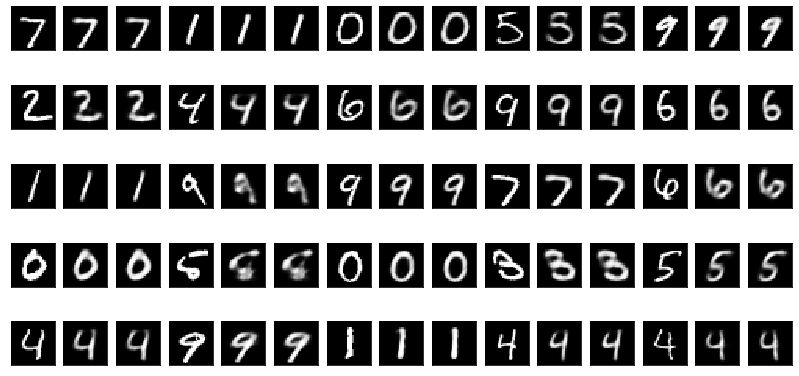

In [75]:
plot_reconstructions(loss_vae, [enc, dec])

In [9]:
def plot_interpolations(encoder, decoder):
    with torch.no_grad():
        batch = (test_loader.dataset.data[:10].float() / 255.)
        batch = batch.view(-1, D).to(device)
        batch = encoder(batch)
        z_0 = batch[:5, :d].view(5, 1, d)
        z_1 = batch[5:, :d].view(5, 1, d)
        
        alpha = torch.linspace(0., 1., 10).to(device)
        alpha = alpha.view(1, 10, 1)
        
        interpolations_z = (z_0 * alpha + z_1 * (1 - alpha))
        interpolations_z = interpolations_z.view(50, d)
        interpolations_x = torch.sigmoid(decoder(interpolations_z))
        interpolations_x = interpolations_x.view(5, 10, 28, 28).cpu().numpy()
    
    fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i in range(50):
        axes[i // 10, i % 10].imshow(interpolations_x[i // 10, i % 10], cmap='gray')

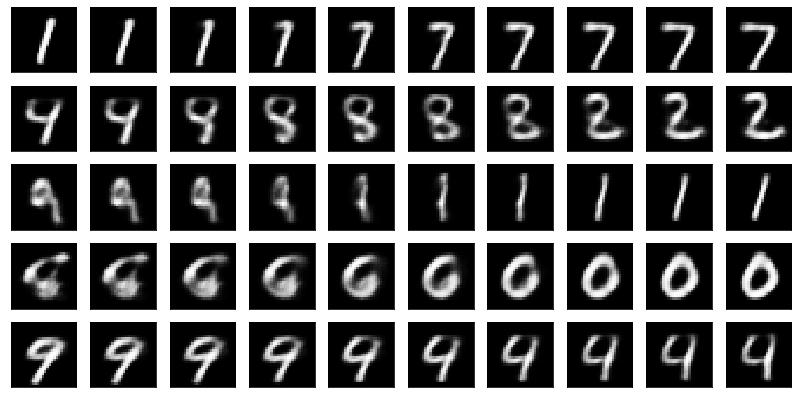

In [77]:
plot_interpolations(enc, dec)

In [80]:
def plot_tsne(objects, labels):
    from sklearn.manifold import TSNE
    embeddings = TSNE(n_components=2).fit_transform(objects)
    plt.figure(figsize=(8, 8))
    for k in range(10):
        embeddings_for_k = embeddings[labels == k]
        plt.scatter(embeddings_for_k[:, 0], embeddings_for_k[:, 1],
                    label='{}'.format(k))
    plt.legend()

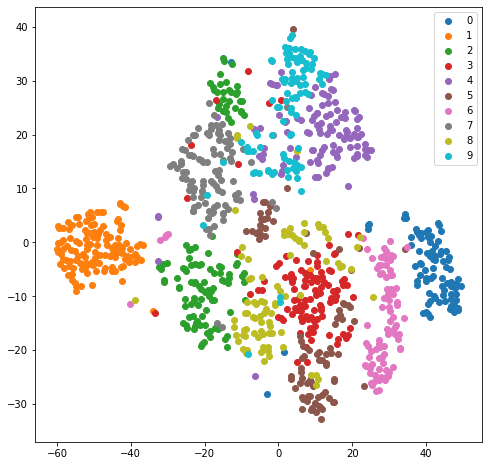

In [81]:
with torch.no_grad():
    batch = (test_loader.dataset.data[:1000].float() / 255.)
    batch = batch.view(-1, D).to(device)
    
    latent_variables = enc(batch)[:, :d]
    latent_variables = latent_variables.cpu().numpy()
    labels = test_loader.dataset.targets[:1000].numpy()
    
plot_tsne(latent_variables, labels)

# [DRAW](http://proceedings.mlr.press/v37/gregor15.pdf)

To illustrate the flexibility of VAE framework, this section considers Deep Recurrent Attentive Writer Model. The goal of the model was to improve image generation by allowing the model to generate images step-by-step. Instead of encoding image into a fixed-size latent representation $z$, the model uses a recurrent neural network to generate a sequence of representations $z_1, \dots, z_T$ that capture the generation steps.

From the probabilistic viewpoint, the model puts standard Gaussian prior over $p(z_i) = \mathcal N(0, I)$ and uses Bernoulli distribution to model $p(x | z, \theta)$ just as in the standard VAE. But now the encoder uses a flexible autoregressive model
\begin{align}
q(z_1, \dots, z_T \mid x, \phi) = \prod_{t=1}^T q(z_t \mid z_1, \dots, z_{t-1}, x, \phi).
\end{align}
Equations (3)-(8) from the [paper](http://proceedings.mlr.press/v37/gregor15.pdf) describe the details of the architecture. At each timestep $t$ the model stores "canvas" $c_t$, a D-dimensional vector that sequentially approximates the input sample $x$. 

**First**, the recurrent *encoder* computes the approximation error $$\hat{x}_t = x - \sigma(c_{t -1})$$ and computes next hidden state $h^{enc}_t$ based on the approximation error $\hat{x}_t$, the input sample $x$ and the hiddent state of decoder network:
\begin{align}
r_t &= \textit{read}(x, \hat{x}_t, h_{t - 1}^{dec}) \\
h_t^{enc} & = RNN^{enc} (h^{enc}_{t - 1}, [r_t, h_{t - 1}^{dec}]).
\end{align}
**Second**, similarly to VAE, the hidden state $h_t^{enc}$ defines mean and variance of a fully-factorised Gaussian distribution
$$z_t \sim q(z_t \mid h_t^{enc}).$$
**Third**, the *decoder* RNN updates the canvas:
\begin{align}
h^{dec}_t &= RNN^{dec}(h_{t - 1}^{dec}, z_t) \\
c_t &= c_{t - 1} + \textit{write}(h_t^{dec}) \\.
\end{align}

After making $T$ timesteps the model computes $p(x | z)$ (i.e. reconstruction error) using the canvas $c_T$ as logits to initialize Bernoulli distribution.

The $\textit{read}$ and $\textit{write}$ modules in the simplest instantiation are a concatenation of two inputs and a linear layer
\begin{align}
\textit{read}(x, \hat{x}_t, h^{dec}_{t-1}) = [x, \hat{x}_t] \\
\textit{write}(h_t^{dec}) = W(h_t^{dec}),
\end{align}

although they can be replaced with an attentive neural network to improve the model performance.

Below we use the simplest instantiation with GRU cells for encoder and decoder.

In [8]:
def loss_draw(x, read, enc_rnn, dec_rnn, write, T, h_enc_init, h_dec_init,
              canvas_init):
    """
    TODO
    returns
    1. the avergave value of negative ELBO across the minibatch x
    2. and the canvases for each step of computations
    """
    # batch_size = x.size(0)
    # canvases = [0] * (T + 1)
    # canvases[0] = canvas_init.view(1, -1).repeat(batch_size, 1)
    # h_enc = h_enc_init.view(1, -1).repeat(batch_size, 1)
    # h_dec = h_dec_init.view(1, -1).repeat(batch_size, 1)
    batch_size = x.size(0)
    canvases = torch.empty(T+1, batchsize, D)
    canvases[0, ...] = canvas_init.view.repeat(batch_size, 1)
    
    h_enc = h_enc_init.repeat(batch_size, 1)
    h_dec = h_dec_init.repeat(batch_size, 1)
    
    kl_loss = torch.empty()
    
    prior_dist = Independent(
        Normal(
            torch.zeros(batch_size, d),
            torch.ones(batch_size, d)
        ),
        reinterpreted_batch_ndims=1
    )
    
    for t in range(T):
        xerr_t = x - torch.sigmoid(canvases[t])
        r_t = read(x, xerr_t, h_dec)
        
        h_enc = enc_rnn(
            torch.cat([r_t, h_dec], dim=1),
            h_enc
        )
        
        # no linear layer here, stupidly, hidden state really is just the distributions parameters
        z_t_mu, z_t_log_sigma = h_enc[:, :d], h_enc[:, d:]
        z_t_dist = Independent(Normal(z_t_mu, torch.exp(z_t_log_sigma)), reinterpreted_batch_ndims=1)
        
        z_t_sample = z_t_dist.rsample()
        
        h_dec = dec_rnn(
            z_t_sample,
            h_dec
        )
        
        canvases[t+1] = canvases[t] + write(h_dec)
        
        kl_loss += kl_divergence(z_t_dist, prior_dist).mean()
    
    # rec_loss = torch.nn.CrossEntropyLoss()
    #loss_value = rec_loss(x, canvases[-1]) + kl_loss
    x_dist = Independent(
        Bernoulli(logits=canvases[T]),
        reinterpreted_batch_ndims=1
    )
    
    rec_loss = - x_dist.log_prob(x).mean()
    
    loss = rec_loss + kl_loss

    return loss, canvases


def sample_draw(dec_rnn, write, T, n_samples):
    with torch.no_grad():
        batch_size = n_samples
        canvases = [0] * (T + 1)
        canvases[0] = torch.zeros(batch_size, D)
        h_dec = torch.zeros(batch_size, nh).to(device) # the initial state
    
        for t in range(T):
            z_t = torch.randn(n_samples, d).to(device)
            h_dec = draw_model.dec_rnn(z_t, h_dec)
            canvases[t + 1] = canvases[t] + write(h_dec).cpu()
        
        canvases = torch.stack(canvases, 0)[1:]
        canvases = torch.sigmoid(canvases)
        canvases = canvases.view(T, n_samples, 28, 28)
        

    return canvases

In [97]:
class Simple_Read(nn.Module):
    def __init__(self, input_size, image_shape, *args, **kwargs):
        super(Simple_Read, self).__init__()
        
        self.input_size = input_size
        self.output_size = 2 * np.prod(image_shape)
        
    def forward(self, x, x_err, h_dec):
        return torch.cat([x, x_err], dim=1)
    
    
class Simple_Write(nn.Module):
    def __init__(self, input_size, image_shape, *args, **kwargs):
        super(Simple_Write, self).__init__()
        
        self.input_size = input_size
        self.output_size = np.prod(image_shape)
        self.W = nn.Linear(self.input_size, self.output_size)
        
    def forward(self, h_dec):
        return self.W(h_dec)

In [112]:
def filterbank(g_X, g_Y, sigma_sq, delta, filter_size, height, width, batch_size):
    
    # shape [batch_size, filter_size]
    offsets = torch.arange(filter_size, dtype=torch.float32) - filter_size/2. + 0.5
    mu_X = (g_X.unsqueeze(-1).repeat(1, filter_size)
            + offsets * delta.unsqueeze(-1).repeat(1, filter_size))
    mu_Y = (g_Y.unsqueeze(-1).repeat(1, filter_size)
            + offsets * delta.unsqueeze(-1).repeat(1, filter_size))

    # shape [batch_size, filter_size, height/width]
    mu_X = mu_X.unsqueeze(-1).repeat(1, 1, height)
    mu_Y = mu_Y.unsqueeze(-1).repeat(1, 1, width)
    a = torch.arange(1, height+1, dtype=torch.float32).repeat(batch_size, filter_size, 1)
    b = torch.arange(1, width+1, dtype=torch.float32).repeat(batch_size, filter_size, 1)

    sigma_sq = sigma_sq.view(-1, 1, 1)

    F_X = torch.exp(-0.5 * (a-mu_X)**2/ sigma_sq)
    F_X = F_X / (F_X.sum(keepdim=True, axis=2) + TINY)

    F_Y = torch.exp(-0.5 * (a-mu_Y)**2/ sigma_sq)
    F_Y = F_Y / (F_Y.sum(keepdim=True, axis=2) + TINY)

    return F_X, F_Y
    
    
class Selective_Read(nn.Module):
    def __init__(self, input_size, image_shape, filter_size):
        super(Selective_Read, self).__init__()
        
        self.input_size = input_size
        self.image_shape = image_shape
        self.filter_size = filter_size
        
        if len(self.image_shape) == 3:
            self.height, self.width, self.depth = self.image_shape
        elif len(self.image_shape) == 2:
            self.height, self.width = self.image_shape
            self.depth = 1
        else:
            raise AttributeError
            
        self.output_size = 2 * self.depth * self.filter_size**2
        
        self.W = nn.Linear(self.input_size, 5)
        
    def forward(self, x, x_err, h_dec):
        
        batch_size = x.size(0)
        
        filter_params = self.W(h_dec)
        
        # shape [batch_size], [batch_size], [batch_size], [batch_size], [batch_size]
        g_X, g_Y, log_sigma_sq, log_delta, log_gamma = torch.unbind(filter_params, dim=1)
        
        # ensures reasonable scale (whole image) for uninitialsed network
        g_X = (self.height + 1)/2 * (g_X + 1)
        g_Y = (self.width + 1)/2 * (g_Y + 1)
        delta = (max(self.height, self.width) - 1)/(self.filter_size - 1) * torch.exp(log_delta)
        
        # reparametrize from log scale
        sigma_sq = torch.exp(log_sigma_sq)
        gamma = torch.exp(log_gamma)
        
        # [batch_size, filter_size, height/width]
        F_X, F_Y = filterbank(g_X, g_Y, sigma_sq, delta, self.filter_size, self.height, self.width, batch_size)
        # [batch_size, height/width, filter_size]
        F_X_T = torch.transpose(F_X, 2, 1)
        
        # [batch_size*depth, h/w, filter_size]
        F_X_T = F_X_T.repeat(self.depth, 1, 1)
        # [batch_size*depth, filter_size, h/w]        
        F_Y = F_Y.repeat(self.depth, 1, 1)
        
        # [batch_size, 1]
        gamma = gamma.view(-1, 1)
        
        # [batch_size*depth, h, w]
        x_shape = (batch_size*self.depth, self.height, self.width)
        
        # with pytorch's batch-matrix-multiply
        # [b*d, N, w] * [b*d, w, h] * [b*d, h, N] -> [b*d, N, N] -> [b, d*N*N]
        x_filtered = F_Y.bmm(x.view(*x_shape)).bmm(F_X_T).view(batch_size, -1)
        x_err_filtered = F_Y.bmm(x_err.view(*x_shape)).bmm(F_X_T).view(batch_size, -1)
        
        # with pytorch's einsum
        #x_filtered = gamma * torch.einsum(
        #    "njb,nab,nia->nij", F_Y, x.view(-1, *self.image_shape), F_X).reshape(batch_size, -1)
        #x_err_filtered = gamma * torch.einsum(
        #    "njb,nab,nia->nij", F_Y, x_err.view(-1, *self.image_shape), F_X).reshape(batch_size, -1)
        
        return (gamma * torch.cat([x_filtered, x_err_filtered], dim=1))

    
class Selective_Write(nn.Module):
    def __init__(self, input_size, image_shape, filter_size):
        super(Selective_Write, self).__init__()
        
        self.input_size = input_size
        self.image_shape = image_shape
        self.filter_size = filter_size
        
        if len(self.image_shape) == 3:
            self.height, self.width, self.depth = self.image_shape
        elif len(self.image_shape) == 2:
            self.height, self.width = self.image_shape
            self.depth = 1
        else:
            raise AttributeError
        
        self.patch_size = self.depth * self.filter_size**2
        self.output_size = np.prod(self.image_shape)
        
        self.W1 = nn.Linear(self.input_size, self.patch_size)
        self.W2 = nn.Linear(self.input_size, 5)
        
    def forward(self, h_dec):
        
        batch_size = h_dec.size(0)
        
        w = self.W1(h_dec)
        filter_params = self.W2(h_dec)
        
        # shape [batch_size], [batch_size], [batch_size], [batch_size], [batch_size]
        g_X, g_Y, log_sigma_sq, log_delta, log_gamma = torch.unbind(filter_params, dim=1)
        
        # ensures reasonable scale (whole image) for uninitialsed network
        g_X = (self.height + 1)/2 * (g_X + 1)
        g_Y = (self.width + 1)/2 * (g_Y + 1)
        delta = (max(self.height, self.width) - 1)/(self.filter_size - 1) * torch.exp(log_delta)
        
        # reparametrize from log scale
        sigma_sq = torch.exp(log_sigma_sq)
        gamma = torch.exp(log_gamma)
        
        
        # [batch_size, filter_size, height/width]
        F_X, F_Y = filterbank(g_X, g_Y, sigma_sq, delta, self.filter_size, self.height, self.width, batch_size)
        # [batch_size, height/width, filter_size]
        F_Y_T = torch.transpose(F_Y, 2, 1)
    
        # [batch_size*depth, h/w, filter_size]
        F_X = F_X.repeat(self.depth, 1, 1)
        # [batch_size*depth, filter_size, h/w]        
        F_Y_T = F_Y_T.repeat(self.depth, 1, 1)        
        
        # [batch_size, 1]
        gamma = gamma.view(-1, 1)
        
        # with pytorch's batch-matrix-multiply
        # [b*d, N, N]
        w = w.view(batch_size*self.depth, self.filter_size, self.filter_size)
        # [b*d, w, N] * [b*d, N, N] * [b*d, N, h] -> [b*d, w, h] -> [b, d*w*h]
        w_filtered = 1./gamma * F_Y_T.bmm(w.bmm(F_X)).view(-1, self.output_size)
        
        return w_filtered


    

In [113]:
class DRAW(nn.Module):
    def __init__(
        self,
        read=Simple_Read,
        write=Simple_Write,
        horizon=16,
        latent_dimension=16,
        hidden_size=128,
        input_size=28*28,
        image_shape=(28,28),
        read_filter_size=3,
        write_filter_size=5
    ):
        super(DRAW, self).__init__()
        
        # self.read_mode = read
        # self.write_mode = write
        
        self.horizon = horizon
        self.latent_dimension = latent_dimension
        self.hidden_size = hidden_size
        self.image_shape = image_shape
        self.read_filter_size = read_filter_size
        self.write_filter_size = write_filter_size
        
        self.input_size = np.prod(image_shape)
        
        self.read = read(
            input_size=self.hidden_size, image_shape=self.image_shape, filter_size=self.read_filter_size)
        self.write = write(
            input_size=self.hidden_size, image_shape=self.image_shape, filter_size=self.write_filter_size)

        self.read_size = self.read.output_size
        self.write_size = self.write.output_size # write_filter_size**2

        self.enc_rnn = nn.GRUCell(self.read_size + self.hidden_size, self.hidden_size)
        self.dec_rnn = nn.GRUCell(self.latent_dimension, self.hidden_size)
        
        self.encoder_net = nn.Linear(self.hidden_size, self.latent_dimension*2)

        # initial hidden states and the initial approximation to a digit
        self.h_enc_init = nn.Parameter(torch.zeros(self.hidden_size))
        self.h_dec_init = nn.Parameter(torch.zeros(self.hidden_size))
        self.canvas_init = nn.Parameter(torch.zeros(self.input_size))

    def forward(self, x):
        batch_size = x.size(0)
        canvases = torch.empty(self.horizon+1, batch_size, self.input_size)
        canvases[0, :, :] = self.canvas_init.repeat(batch_size, 1)

        h_enc = self.h_enc_init.repeat(batch_size, 1)
        h_dec = self.h_dec_init.repeat(batch_size, 1)

        kl_loss = torch.zeros(self.horizon)

        pz = Independent(
            Normal(
                torch.zeros(batch_size, self.latent_dimension),
                torch.ones(batch_size, self.latent_dimension)
            ),
            reinterpreted_batch_ndims=1
        )

        for t in range(self.horizon):
            xerr_t = x - torch.sigmoid(canvases[t])
            r_t = self.read(x, xerr_t, h_dec)

            h_enc = self.enc_rnn(
                torch.cat([r_t, h_dec], dim=1),
                h_enc
            )

            # no linear layer here, stupidly, hidden state really is just the distributions parameters
            # z_t_mu, z_t_log_sigma = h_enc[:, :d], h_enc[:, d:]
            
            qz_params = self.encoder_net(h_enc)
            z_t_mu, z_t_log_sigma = qz_params[:, :self.latent_dimension], qz_params[:, self.latent_dimension:]
            
            qz_t = Independent(Normal(z_t_mu, torch.exp(z_t_log_sigma)), reinterpreted_batch_ndims=1)

            z_t_sample = qz_t.rsample()

            h_dec = self.dec_rnn(
                z_t_sample,
                h_dec
            )

            canvases[t+1] = canvases[t] + self.write(h_dec)

            kl = kl_divergence(qz_t, pz)
            # sum along component dimension through Independent
            # average along batch dimension
            kl_loss[t] = kl_divergence(qz_t, pz).mean()
            
        # rec_loss = torch.nn.CrossEntropyLoss()
        #loss_value = rec_loss(x, canvases[-1]) + kl_loss
        x_dist = Independent(
            Bernoulli(logits=canvases[-1]),
            reinterpreted_batch_ndims=1
        )

        # mean along batch dimension
        rec_loss = - x_dist.log_prob(x).mean()

        loss = rec_loss + kl_loss.sum()

        return loss, canvases
    
    def sample(self, n_samples):
        canvases = torch.empty(self.horizon+1, n_samples, self.input_size)
        canvases[0, :, :] = self.canvas_init.repeat(n_samples, 1)

        h_dec = self.h_dec_init.repeat(n_samples, 1).to(device)
        
        for t in range(self.horizon):
            z_t = torch.randn(n_samples, self.latent_dimension).to(device)
            h_dec = self.dec_rnn(z_t, h_dec)
            canvases[t+1] = canvases[t] + self.write(h_dec).cpu()
            
        canvases = torch.sigmoid(canvases)
        canvases = canvases.view(-1, n_samples, *self.image_shape)
        
        return canvases

## Task 2: VAE Loss function

Implement the loss function for DRAW

## Training

In [114]:
def train_model(model, batch_size=64, num_epochs=3, learning_rate=1e-3, lr_step_size=10, lr_gamma=0.5):
    # Training dataset
    train_loader = torch.utils.data.DataLoader(
        MNIST(root='../../data/', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, pin_memory=True)
    # Test dataset
    test_loader = torch.utils.data.DataLoader(
        MNIST(root='../../data/', train=False, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, pin_memory=True)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(train_loader):
            total = len(train_loader)
            optimizer.zero_grad()
            batch = batch.view(-1, model.input_size).to(device)
            loss_value, _ = model(batch)            
            loss_value.backward()
            train_losses.append(loss_value.item())
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            optimizer.step()
        scheduler.step()
            
        test_loss = 0.
        for i, (batch, _) in enumerate(test_loader):
            with torch.no_grad():
                batch = batch.view(-1, model.input_size).to(device)
                batch_loss, _ = model(batch)
                test_loss += (batch_loss - test_loss) / (i + 1)
        print('\nTest loss after an epoch: {}'.format(test_loss))

In [139]:
draw_mnist_model = DRAW(read=Selective_Read, write=Selective_Write, hidden_size=256, latent_dimension=100, horizon=32)
draw_mnist_model.to(device)

DRAW(
  (read): Selective_Read(
    (W): Linear(in_features=256, out_features=5, bias=True)
  )
  (write): Selective_Write(
    (W1): Linear(in_features=256, out_features=25, bias=True)
    (W2): Linear(in_features=256, out_features=5, bias=True)
  )
  (enc_rnn): GRUCell(274, 256)
  (dec_rnn): GRUCell(100, 256)
  (encoder_net): Linear(in_features=256, out_features=200, bias=True)
)

In [140]:
train_model(draw_mnist_model, batch_size=64, num_epochs=50, learning_rate=1e-3, lr_step_size=5, lr_gamma=0.5)

Train loss: 140.38296508789062 Batch 930 of 938           
Test loss after an epoch: 135.59371948242188
Train loss: 129.4799346923828 Batch 930 of 938            
Test loss after an epoch: 119.14923095703125
Train loss: 108.91741943359375 Batch 930 of 938           
Test loss after an epoch: 112.55155944824219
Train loss: 116.40955352783203 Batch 930 of 938           
Test loss after an epoch: 108.98535919189453
Train loss: 121.35086059570312 Batch 930 of 938           
Test loss after an epoch: 124.22443389892578
Train loss: 116.38584899902344 Batch 930 of 938           
Test loss after an epoch: 113.01995086669922
Train loss: 108.47042846679688 Batch 930 of 938           
Test loss after an epoch: 108.56742858886719
Train loss: 110.38827514648438 Batch 930 of 938           
Test loss after an epoch: 105.9934310913086
Train loss: 104.0525894165039 Batch 930 of 938            
Test loss after an epoch: 103.66381072998047
Train loss: 100.0986328125 Batch 930 of 938               
Test l

KeyboardInterrupt: 

## Visualisation
The following two snippets visualize model samples and the generation procedure. 
- Did DRAW outperform VAE in terms of loss? 
- Is there any noticeable difference in the quality of samples?

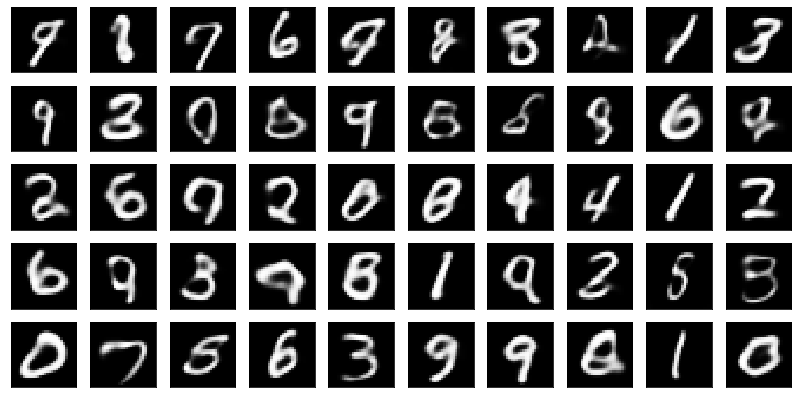

In [144]:
# plots random samples

with torch.no_grad():
    samples = draw_mnist_model.sample(n_samples=50)
    # samples = sample_draw(draw_model.dec_rnn, draw_model.write, draw_model.horizon, n_samples=50)

plot_samples(samples[-1])

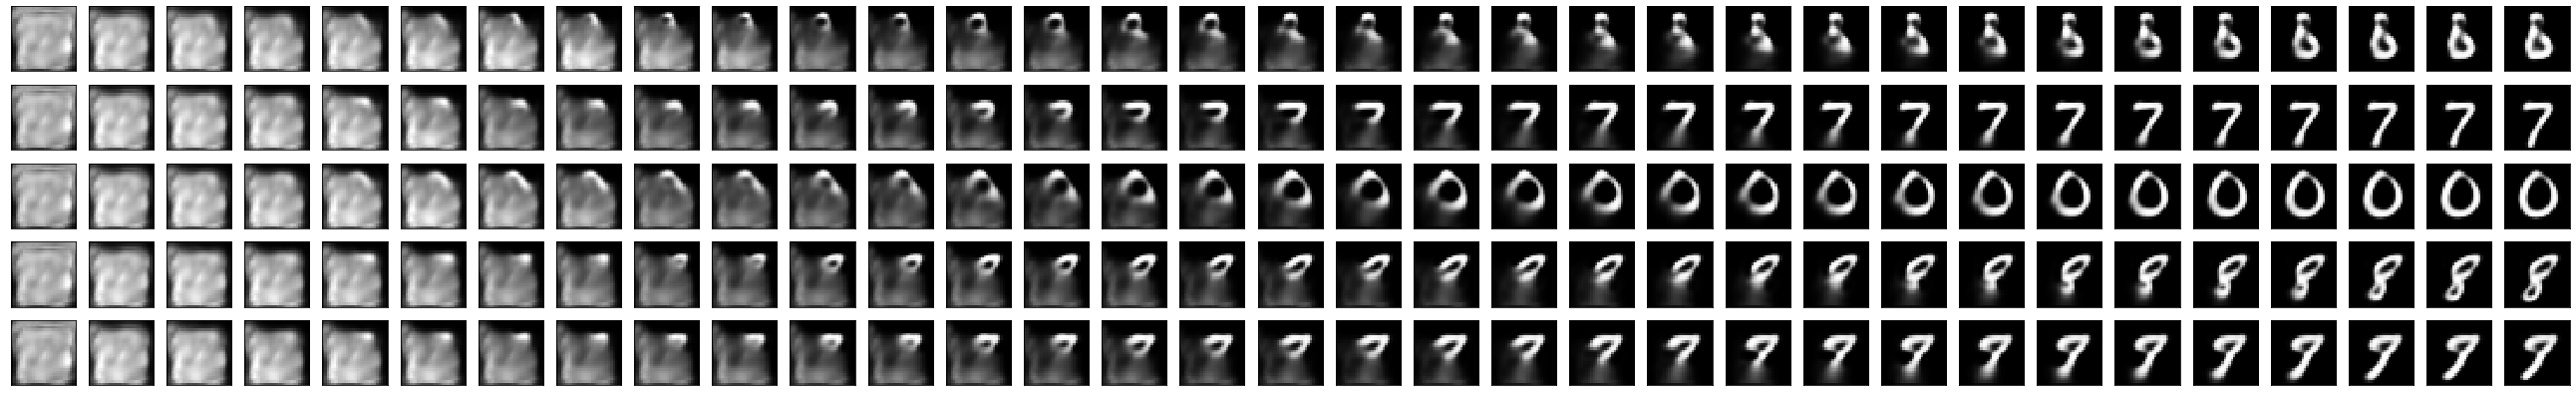

In [146]:
# plots the steps of image generation
with torch.no_grad():
    samples = draw_mnist_model.sample(n_samples=50)
    samples = samples.permute(1, 0, 2, 3).contiguous().view(-1, 28, 28)
    plot_samples(samples, h=5, w=33)

In [117]:
def train_svhn_model(model, batch_size=64, num_epochs=3, learning_rate=1e-3, lr_step_size=10, lr_gamma=0.5):
    # Training dataset
    train_loader = torch.utils.data.DataLoader(
        SVHN(root='../../data/', split='train', download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, pin_memory=True)
    # Test dataset
    test_loader = torch.utils.data.DataLoader(
        SVHN(root='../../data/', split='test', download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, pin_memory=True)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(train_loader):
            total = len(train_loader)
            optimizer.zero_grad()
            batch = batch.view(-1, model.input_size).to(device)
            loss_value, _ = model(batch)            
            loss_value.backward()
            train_losses.append(loss_value.item())
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            optimizer.step()
        scheduler.step()
            
        test_loss = 0.
        for i, (batch, _) in enumerate(test_loader):
            with torch.no_grad():
                batch = batch.view(-1, model.input_size).to(device)
                batch_loss, _ = model(batch)
                test_loss += (batch_loss - test_loss) / (i + 1)
        print('\nTest loss after an epoch: {}'.format(test_loss))

In [121]:
draw_svhn_model = DRAW(
    read=Selective_Read,
    write=Selective_Write,
    image_shape=(32,32,3),
    hidden_size=512,
    latent_dimension=100,
    read_filter_size=12,
    write_filter_size=12,
    horizon=32,
)
draw_svhn_model.to(device)

DRAW(
  (read): Selective_Read(
    (W): Linear(in_features=512, out_features=5, bias=True)
  )
  (write): Selective_Write(
    (W1): Linear(in_features=512, out_features=432, bias=True)
    (W2): Linear(in_features=512, out_features=5, bias=True)
  )
  (enc_rnn): GRUCell(1376, 512)
  (dec_rnn): GRUCell(100, 512)
  (encoder_net): Linear(in_features=512, out_features=200, bias=True)
)

In [127]:
def n_model_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n_model_parameters(draw_mnist_model)
n_model_parameters(draw_svhn_model.dec_rnn)

943104

In [122]:
train_svhn_model(draw_svhn_model, batch_size=64, num_epochs=100, learning_rate=1e-3, lr_step_size=5, lr_gamma=0.5)

Using downloaded and verified file: ../../data/train_32x32.mat
Using downloaded and verified file: ../../data/test_32x32.mat
Train loss: 1864.5697021484375 Batch 930 of 1145           

KeyboardInterrupt: 

# Optional Task
If you have already completed the above tasks, try proposing a network modification to improve its performance on the test set.